# Load json & เตรียมข้อมูล

In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# โหลดข้อมูลจากไฟล์ JSON
with open('../you_path/Features_6_Genre.json', 'r') as fp:
    data = json.load(fp)

# เตรียมข้อมูลและ labels
X = []
y = []
for genre, features_list in data.items():
    for features in features_list:
        # แปลง dictionary ของคุณสมบัติเป็น array
        feature_array = []
        for feature in features.values():
            feature_array.extend(feature)
        X.append(feature_array)
        y.append(genre)

# แปลงข้อมูลเป็น numpy array
X = np.array(X)
y = np.array(y)

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# การทำ normalization/standardization กับข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape ข้อมูลสำหรับ CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Training Model

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization

# การเข้ารหัส labels (one-hot encoding)
label_encoder = LabelEncoder()
# แปลงป้ายกำกับสำหรับชุดฝึกให้เป็นค่าตัวเลขและทำ one-hot encoding
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
# แปลงป้ายกำกับสำหรับชุดทดสอบให้เป็นค่าตัวเลขและทำ one-hot encoding
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# กำหนดสถาปัตยกรรมของโมเดล CNN
# ปรับโมเดลใหม่
model = Sequential([
    # ชั้น Conv1D พร้อมฟิลเตอร์ 32 ขนาด 3 และ activation 'relu'
        Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
        # Normalization ชั้น Conv1D
        BatchNormalization(),
        # ชั้น MaxPooling1D ขนาด 2
        MaxPooling1D(2),
        # ชั้น Conv1D พร้อมฟิลเตอร์ 64 ขนาด 3 และ activation 'relu'
        Conv1D(64, 3, activation='relu'),
        # Normalization ชั้น Conv1D
        BatchNormalization(),
        # ชั้น MaxPooling1D ขนาด 2
        MaxPooling1D(2),
        # ชั้น Conv1D พร้อมฟิลเตอร์ 128 ขนาด 3 และ activation 'relu'
        Conv1D(128, 3, activation='relu'),  # เพิ่มจำนวนชั้นซ่อน
        # Normalization ชั้น Conv1D
        BatchNormalization(),
        # ชั้น MaxPooling1D ขนาด 2
        MaxPooling1D(2),
        # Flatten ชั้นเพื่อแปลงข้อมูลให้เป็นเวกเตอร์
        Flatten(),
        # ชั้น Dense พร้อม 256 หน่วยและ activation 'relu'
        Dense(256, activation='relu'),  # เพิ่มจำนวนหน่วยในชั้นซ่อน
        # Dropout ชั้นเพื่อป้องกัน overfitting
        Dropout(0.5),
        # ชั้น Dense สำหรับการทำนาย พร้อม activation 'softmax'
        Dense(len(label_encoder.classes_), activation='softmax')
])

# คอมไพล์โมเดลพร้อม optimizer, loss function, และ metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
# ฝึกโมเดลใหม่
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/50
73/73 [==============================] - 1s 10ms/step - loss: 1.0420 - accuracy: 0.6958 - val_loss: 1.7746 - val_accuracy: 0.2012
Epoch 2/50
73/73 [==============================] - 1s 10ms/step - loss: 0.4756 - accuracy: 0.8340 - val_loss: 2.8957 - val_accuracy: 0.1672
Epoch 3/50
73/73 [==============================] - 1s 10ms/step - loss: 0.3011 - accuracy: 0.8962 - val_loss: 3.1597 - val_accuracy: 0.1692
Epoch 4/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2252 - accuracy: 0.9189 - val_loss: 1.8969 - val_accuracy: 0.5095
Epoch 5/50
73/73 [==============================] - 1s 10ms/step - loss: 0.1680 - accuracy: 0.9399 - val_loss: 0.7627 - val_accuracy: 0.7057
Epoch 6/50
73/73 [==============================] - 1s 9ms/step - loss: 0.1563 - accuracy: 0.9451 - val_loss: 0.4754 - val_accuracy: 0.8208
Epoch 7/50
73/73 [==============================] - 1s 9ms/step - loss: 0.1121 - accuracy: 0.9597 - val_loss: 0.3336 - val_accuracy: 0.8769
Epoch 8/50
73/7

# ประเมิณ Model

In [4]:
from sklearn.metrics import classification_report

# ประเมินผลโมเดล
y_pred = model.predict(X_test)  # ทำนายผลลัพธ์จากชุดทดสอบ
y_pred_classes = np.argmax(y_pred, axis=1)  # แปลงค่าผลลัพธ์เป็นคลาสที่มีค่าสูงสุด
y_true = np.argmax(y_test_encoded, axis=1)  # แปลงค่าป้ายกำกับจริงเป็นคลาสที่มีค่าสูงสุด

# แสดงผลการประเมินผลลัพธ์ของโมเดล
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

   Classical       0.97      0.97      0.97       193
     Country       0.96      0.94      0.95       171
      HipHop       0.99      0.86      0.92       159
        Jazz       0.85      0.95      0.89       134
       Metal       0.94      0.96      0.95       175
        Rock       0.89      0.92      0.91       167

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.94      0.93      0.94       999



In [5]:
from sklearn.model_selection import KFold

# ฟังก์ชันสำหรับสร้างโมเดล
def build_model():
    model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),  # เพิ่มจำนวนชั้นซ่อน
    BatchNormalization(),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation='relu'),  # เพิ่มจำนวนหน่วยในชั้นซ่อน
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# การทำ K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X):
    # แบ่งข้อมูลออกเป็นชุดฝึกและชุดทดสอบสำหรับ Cross-Validation
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    # ทำการ Normalize ข้อมูล
    X_train_cv = scaler.fit_transform(X_train_cv)
    X_val_cv = scaler.transform(X_val_cv)
    
    # Reshape ข้อมูลเพื่อให้เหมาะสมกับโมเดล
    X_train_cv = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
    X_val_cv = X_val_cv.reshape(X_val_cv.shape[0], X_val_cv.shape[1], 1)
    
    # แปลงป้ายกำกับให้เป็นแบบ one-hot encoding
    y_train_cv_encoded = to_categorical(label_encoder.fit_transform(y_train_cv))
    y_val_cv_encoded = to_categorical(label_encoder.transform(y_val_cv))
    
    # สร้างและฝึกโมเดลสำหรับ Cross-Validation
    model_cv = build_model()
    model_cv.fit(X_train_cv, y_train_cv_encoded, epochs=50, batch_size=32, verbose=0)
    
    # ประเมินโมเดลด้วยชุดทดสอบ
    scores = model_cv.evaluate(X_val_cv, y_val_cv_encoded, verbose=0)
    cv_scores.append(scores[1])  # ใช้ค่า accuracy ที่ได้

# แสดงผลลัพธ์ของ Cross-Validation
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores)}')
print(f'Standard Deviation of CV Accuracy: {np.std(cv_scores)}')


Cross-Validation Accuracy Scores: [0.9534534811973572, 0.9324324131011963, 0.9474474191665649, 0.9534534811973572, 0.9459459185600281]
Mean CV Accuracy: 0.9465465426445008
Standard Deviation of CV Accuracy: 0.007691457350982372


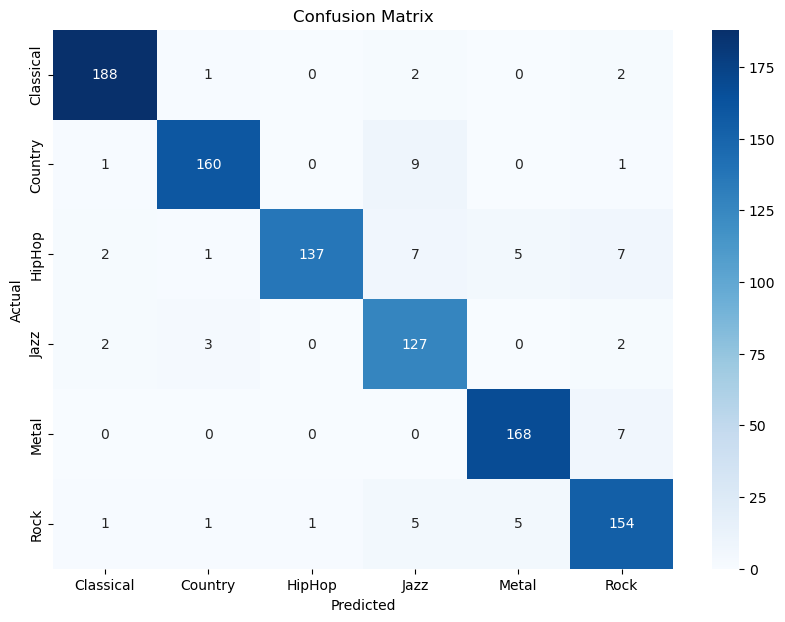

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# การสร้าง Confusion Matrix ใหม่
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# การแสดง Confusion Matrix ใหม่
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# บันทึก Model

In [7]:
# บันทึกโมเดล
model.save('./Final_Model/Music_6_Genre_Full_Song_CNN_Model.h5')

# บันทึก Label Encoder
import pickle
with open('./Final_Model/Label_Encoder_6_Genre_Full_Song.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# บันทึก Scaler
with open('./Final_Model/Scaler_6_Genre_Full_Song.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [8]:
# โหลดโมเดลเพื่อตรวจสอบ
from tensorflow.keras.models import load_model

model = load_model('./Final_Model/Music_6_Genre_Full_Song_CNN_Model.h5')

In [9]:
#โหลด Label Encoder เพื่อตรวจสอบ
with open('./Final_Model/Label_Encoder_6_Genre_Full_Song.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

In [10]:
# โหลด Scaler เพื่อตรวจสอบ
with open('./Final_Model/Scaler_6_Genre_Full_Song.pkl', 'rb') as file:
    scaler = pickle.load(file)